# Imports

In [17]:
!pip install -U -q PyDrive #Comment if not using Google Colab

import os, shutil
from os import path
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import keras
import tensorflow as tf
from keras import models 
from keras import layers
from keras import optimizers
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd 
import scipy.io
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import image
from keras import backend as K
from IPython.display import Image, display
import keras.backend as K

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
import random

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

# Set a random seed
from numpy.random import seed
seed(1)

# Functions

In [18]:
#Adapted from https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [19]:
#Adapted from https://github.com/SadmanSakib93/Stratified-k-fold-cross-validation-Image-classification-keras

def transferBetweenFolders(source, dest, splitRate):   
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        
def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(datasetFolderName+'/'+source+'/'+label+'/', 
                               datasetFolderName+'/'+dest+'/'+label+'/', 
                               splitRate)
        
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred)
    recall=recall_score(y_true, y_pred)
    f1Score=f1_score(y_true, y_pred, average='micro') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, recall, f1Score

In [ ]:
#Adapted from https://keras.io/examples/vision/grad_cam/

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [ ]:
def metrics_val(y_val, pred_val):
    
    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))
    print('F1-score, micro: ',f1_score(y_val, pred_val, average = 'micro'))

# Download Data Using Google Colab

In [2]:
#Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
#Choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

#Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1tQbRH3uO-mwTbViQTNdzs_4x-UnUkoSz' in parents"}).GetList()

for f in file_list:
  #Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: model2.2.h5, id: 1SKFQ-1VRZZvvjp8_ksNBM6FM-qhyErPv
downloading to /root/data/model2.2.h5
title: DataSet.zip, id: 1BeacQpDbIvJCk93KrpJxxsoeAcS_8ySo
downloading to /root/data/DataSet.zip


In [4]:
with zipfile.ZipFile('/root/data/DataSet.zip', 'r') as zip_ref:
    zip_ref.extractall('/root/data')

# Data Preprocessing

In [8]:
#Code used to reorganize the data in to new splits

# #Move all data to the same folders

# #Destination folders
# dst_normal = 'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/AllData/NORMAL'
# dst_pneumonia = 'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/AllData/PNEUMONIA'

# #Original folders
# src_normal = ['C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/train/NORMAL',
#              'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/val/NORMAL',
#              'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/test/NORMAL']

# src_pneumonia = ['C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/train/PNEUMONIA',
#              'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/val/PNEUMONIA',
#              'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/test/PNEUMONIA']

# #Loop to copy data from original folders to destination folders
# for j in src_normal:
#     files = [i for i in os.listdir(j)]
#     for f in files:
#         shutil.copy(path.join(j, f), dst_normal)
        
# for j in src_pneumonia:
#     files = [i for i in os.listdir(j)]
#     for f in files:
#         shutil.copy(path.join(j, f), dst_pneumonia)

# #Create train, val, test split (70, 15, 15)

# #Destination folders
# dst_normal = ['C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet/train/NORMAL',
#              'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet/val/NORMAL',
#              'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet/test/NORMAL']

# dst_pneumonia = ['C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet/train/PNEUMONIA',
#              'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet/val/PNEUMONIA',
#              'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet/test/PNEUMONIA']

# #Source folders
# src_normal = 'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/AllData/NORMAL'
# src_pneumonia = 'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/AllData/PNEUMONIA'

# #Files (images) in source folders
# files_normal = [i for i in os.listdir(src_normal)]
# files_pneumonia = [i for i in os.listdir(src_pneumonia)]

# #Counters
# count_normal = 1
# count_pneumonia = 1

# #Loops to copy images to destination folders
# for f in files_normal:
#     if count_normal <= 1108:
#         shutil.copy(path.join(src_normal, f), dst_normal[0]) 
#     elif count_normal <= (1108+238):
#         shutil.copy(path.join(src_normal, f), dst_normal[1])
#     else:
#         shutil.copy(path.join(src_normal, f), dst_normal[2])
#     count_normal = count_normal + 1
    
# for f in files_pneumonia:
#     if count_pneumonia <= 2993:
#         shutil.copy(path.join(src_pneumonia, f), dst_pneumonia[0]) 
#     elif count_pneumonia <= (2993+640):
#         shutil.copy(path.join(src_pneumonia, f), dst_pneumonia[1])
#     else:
#         shutil.copy(path.join(src_pneumonia, f), dst_pneumonia[2])
#     count_pneumonia = count_pneumonia + 1

In [9]:
#Code used to produce oversampling dataset trough data augmentation

#Data augmentation used
# train_augment_datagen = ImageDataGenerator(rescale = 1./255,
#                                   rotation_range=40,
#                                   width_shift_range=0.2,
#                                   height_shift_range=0.2,
#                                   shear_range=0.2,
#                                   zoom_range=0.2,
#                                   fill_mode='nearest')

# train_augment_set = train_augment_datagen.flow_from_directory('C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet/train/', 
#                                                  target_size = (75, 75),
#                                                  batch_size = 20,
#                                                  class_mode = 'binary',
                                                 
#                                                 )

# count = 1

# for images, labels in train_augment_set:
#     for i in range(20):
#         if labels[i] == 0: #If the data augmented image is of the minority label, save itt
#             matplotlib.image.imsave('C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet_Oversampling/train/NORMAL/augmented'+str(count)+'.jpeg', images[i])
#             count = count + 1
#             if count >= 1885: #When the desired number of images are created aand saved, stop the loop
#                 break
#     if count >= 1885:
#         break

# #After, the train folder name was renamed to train_DataAugmented as to not conflict with the following code

In [10]:
#Code used to produce oversampling dataset trough random oversampling

# classLabels=['NORMAL', 'PNEUMONIA']
# datasetFolderName='C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet_Oversampling'

# X=[]
# Y=[]

# #Save all of the minority class image names
# def prepareNameWithLabels(folderName):
#     sourceFiles=os.listdir(datasetFolderName+'/train/'+folderName)
#     for val in sourceFiles:
#         X.append(val)
#         if(folderName==classLabels[0]):
#             Y.append(0)
#         elif(folderName==classLabels[1]):
#             Y.append(1)
            
# prepareNameWithLabels(classLabels[0])

# #Randomly select one image and duplicate it, until the minority class has the same number of images as the majority
# for i in range(1885):
#     image = random.choice(X)
#     shutil.copy(path.join(datasetFolderName+'/train/'+classLabels[0], image), datasetFolderName+'/train/'+classLabels[0]+'/'+image+str(i)+'.jpeg')
    
# #After, the train folder name was renamed to train_RandomOversampling as to not conflict with the following code

In [11]:
#Code used to produce oversampling dataset trough random undersampling

# classLabels=['NORMAL', 'PNEUMONIA']
# datasetFolderName='C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet_Oversampling'

# X=[]
# Y=[]

# #Save all of the majority class image names
# def prepareNameWithLabels(folderName):
#     sourceFiles=os.listdir(datasetFolderName+'/train/'+folderName)
#     for val in sourceFiles:
#         X.append(val)
#         if(folderName==classLabels[0]):
#             Y.append(0)
#         elif(folderName==classLabels[1]):
#             Y.append(1)
            
# prepareNameWithLabels(classLabels[1])

# #Randomly select one image and delete it, until the majority class has the same number of images as the minority
# for i in range(1885):
#     image = random.choice(X)
#     os.remove(datasetFolderName+'/train/'+classLabels[1]+'/'+image)
#     X.remove(image)
    
# #After, the train folder name was renamed to train_RandomUndersampling as to not conflict with the following code

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255)

#Generator for augmented data
train_augment_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.4,
                                  fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
train_set = train_datagen.flow_from_directory('/root/data/DataSet/train/', 
                                                 target_size = (75, 75),
                                                 batch_size = 20,
                                                 class_mode = 'binary',
                                                 color_mode = 'grayscale',
                                                 seed=1
                                                )

train_augment_set = train_augment_datagen.flow_from_directory('/root/data/DataSet/train/', 
                                                 target_size = (75, 75),
                                                 batch_size = 20,
                                                 class_mode = 'binary',
                                                 color_mode = 'grayscale',
                                                 seed=1
                                                )

val_set = val_datagen.flow_from_directory('/root/data/DataSet/val/', 
                                            target_size = (75, 75),
                                            batch_size = 20,
                                            class_mode = 'binary',
                                            color_mode = 'grayscale',
                                            seed=1
                                           )
#To be used for feature extraction of the training data
train_set_fe = train_datagen.flow_from_directory('/root/data/DataSet/train/', 
                                                 target_size = (75, 75),
                                                 batch_size = 1,
                                                 class_mode = 'binary',
                                                 color_mode = 'grayscale',
                                                 seed=1,
                                                 shuffle=False
                                                )
#To be used for the confusion matrix of the validation data
val_set_cm = val_datagen.flow_from_directory('/root/data/DataSet/val/', 
                                            target_size = (75, 75),
                                            batch_size = 1,
                                            class_mode = 'binary',
                                            seed=1,
                                            color_mode = 'grayscale',
                                            shuffle=False
                                           )

test_set = test_datagen.flow_from_directory('/root/data/DataSet/test/', 
                                            target_size = (75, 75),
                                            batch_size = 1,
                                            class_mode = 'binary',
                                            seed=1,
                                            color_mode = 'grayscale',
                                            shuffle = False
                                           )

Found 4101 images belonging to 2 classes.
Found 4101 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 4101 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 877 images belonging to 2 classes.


# Tensorboard

In [5]:
#Create log directory
!mkdir /root/data/logs

#Load tensorboard
%load_ext tensorboard

#Launch tensorboard
%tensorboard --logdir /root/data/logs

In [ ]:
#Used when running a second model

#Delete log folder
#!rm -rf /root/data/logs

# Model Creation and Training

In [ ]:
callbacks_list= [keras.callbacks.TensorBoard(log_dir='/root/data/logs', histogram_freq=1),
                 keras.callbacks.EarlyStopping(monitor = 'acc', patience=3), 
                 keras.callbacks.ModelCheckpoint(filepath="/root/data/DataSet/model.h5", monitor ="val_loss", save_best_only=True)]

In [ ]:
#Model 2.2
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(75,75,1)))
model.add(layers.MaxPooling2D((2,2), strides=2))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2), strides=2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2), strides=2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2), strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=[keras.metrics.Recall(), keras.metrics.AUC(),'acc'])

In [6]:
hist= model.fit(
        train_set,
        steps_per_epoch= 4101//20,
        epochs= 50,
        validation_data=val_set,
        validation_steps=878//20, 
        callbacks=callbacks_list
        )

# Model Assessment

In [ ]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

In [7]:
#model = models.load_model('/root/data/model2.2.h5') #best model

In [16]:
Y_pred = model.predict(val_set_cm,878) 
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(val_set_cm.classes, Y_pred))
print('Classification Report')
target_names = ['Normal', 'Pneumonia']
print(classification_report(val_set_cm.classes, Y_pred, target_names=target_names))
f1 = f1_score(val_set_cm.classes, Y_pred, average='micro')
print('F1-Score: ', f1)

Confusion Matrix
[[227  11]
 [  2 638]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.99      0.95      0.97       238
   Pneumonia       0.98      1.00      0.99       640

    accuracy                           0.99       878
   macro avg       0.99      0.98      0.98       878
weighted avg       0.99      0.99      0.99       878

F1-Score:  0.9851936218678815


In [15]:
Y_pred = model.predict(test_set,877) 
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))
print('Classification Report')
target_names = ['Normal', 'Pneumonia']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))
f1 = f1_score(test_set.classes, Y_pred, average='micro')
print('F1-Score: ', f1)

Confusion Matrix
[[204  33]
 [ 15 625]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.93      0.86      0.89       237
   Pneumonia       0.95      0.98      0.96       640

    accuracy                           0.95       877
   macro avg       0.94      0.92      0.93       877
weighted avg       0.94      0.95      0.94       877

F1-Score:  0.9452679589509693


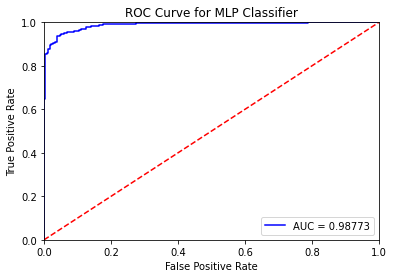

In [ ]:
preds = model.predict(test_set,877) 
fpr, tpr, threshold = metrics.roc_curve(test_set.classes, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve for MLP Classifier')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# K-fold Cross Validation

In [ ]:
#Adapted from https://github.com/SadmanSakib93/Stratified-k-fold-cross-validation-Image-classification-keras

# #Create folder for val partition of the training splits
# !mkdir /root/data/DataSet/val_train_fold
# !mkdir /root/data/DataSet/val_train_fold/NORMAL
# !mkdir /root/data/DataSet/val_train_fold/PNEUMONIA

# datasetFolderName='/root/data/DataSet'
# sourceFiles=[]
# classLabels=['NORMAL', 'PNEUMONIA']

In [ ]:
#Adapted from https://github.com/SadmanSakib93/Stratified-k-fold-cross-validation-Image-classification-keras

# X=[]
# Y=[]

# def prepareNameWithLabels(folderName):
#     sourceFiles=os.listdir(datasetFolderName+'/train/'+folderName)
#     for val in sourceFiles:
#         X.append(val)
#         if(folderName==classLabels[0]):
#             Y.append(0)
#         elif(folderName==classLabels[1]):
#             Y.append(1)
       
# # Organize file names and class labels in X and Y variables
# prepareNameWithLabels(classLabels[0])
# prepareNameWithLabels(classLabels[1])
      
# X=np.asarray(X)
# Y=np.asarray(Y)

# # learning rate
# batch_size = 20
# epochs=50
# activationFunction='relu'

# def getModel():
#     model = models.Sequential()
#     model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(75,75,1)))
#     model.add(layers.MaxPooling2D((2,2), strides=2))
#     model.add(layers.Conv2D(32, (3,3), activation='relu'))
#     model.add(layers.MaxPooling2D((2,2), strides=2))
#     model.add(layers.Conv2D(64, (3,3), activation='relu'))
#     model.add(layers.MaxPooling2D((2,2), strides=2))
#     model.add(layers.Conv2D(128, (3,3), activation='relu'))
#     model.add(layers.MaxPooling2D((2,2), strides=2))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(512, activation='relu'))
#     model.add(layers.Dense(256, activation='relu'))
#     model.add(layers.Dense(1, activation='sigmoid'))

#     model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

#     return model

# # input image dimensions
# img_rows, img_cols =  75, 75

# train_path=datasetFolderName+'/train/'
# validation_path=datasetFolderName+'/val_train_fold/'
# model=getModel()
# acc_avg=[]
# prec_avg=[]
# rec_avg=[]
# f1_agv=[]
# # ===============Stratified K-Fold======================
# skf = StratifiedKFold(n_splits=3, shuffle=True)
# skf.get_n_splits(X, Y)
# foldNum=0
# for train_index, val_index in skf.split(X, Y):
#     #First cut all images from validation to train (if any exists)
#     transferAllClassBetweenFolders('val_train_fold', 'train', 1.0)
#     foldNum+=1
#     print("Results for fold",foldNum)
#     X_train, X_val = X[train_index], X[val_index]
#     Y_train, Y_val = Y[train_index], Y[val_index]
#     # Move validation images of this fold from train folder to the validation folder
#     for eachIndex in range(len(X_val)):
#         classLabel=''
#         if(Y_val[eachIndex]==0):
#             classLabel=classLabels[0]
#         elif(Y_val[eachIndex]==1):
#             classLabel=classLabels[1]
 
#         #Then, copy the validation images to the validation folder
#         shutil.move(datasetFolderName+'/train/'+classLabel+'/'+X_val[eachIndex], 
#                     datasetFolderName+'/val_train_fold/'+classLabel+'/'+X_val[eachIndex])
        
#     train_datagen_kf = ImageDataGenerator(
#                        rescale=1./255,
#                        )
#     validation_datagen_kf = ImageDataGenerator(rescale=1./255)
        
#     #Start ImageClassification Model
#     train_generator_kf = train_datagen_kf.flow_from_directory(
#                           train_path,
#                           target_size=(img_rows, img_cols),
#                           batch_size=batch_size,
#                           class_mode='binary',
#                           color_mode = 'grayscale',
#                           )

#     validation_generator_kf = validation_datagen_kf.flow_from_directory(
#                               validation_path,
#                               target_size=(img_rows, img_cols),
#                               batch_size=batch_size,
#                               class_mode='binary',
#                               color_mode = 'grayscale',
#                               )  
    
#     validation_generator_2 = validation_datagen_kf.flow_from_directory(
#                              validation_path,
#                              target_size=(img_rows, img_cols),
#                              batch_size=1,
#                              class_mode='binary',
#                              color_mode = 'grayscale',
#                              shuffle=False)   
    
#     # fit model
#     callbacks_list= [keras.callbacks.EarlyStopping(monitor = 'acc', patience=5), 
#                      keras.callbacks.ModelCheckpoint(filepath="/root/data/DataSet/my_model.h5", 
#                                                       monitor ="val_loss", save_best_only=True)]
#     model=getModel()

#     history= model.fit(
#         train_generator_kf,
#         epochs= epochs,
#         steps_per_epoch=len(train_index)//batch_size,
#         validation_data=validation_generator_kf,
#         validation_steps=len(val_index)//batch_size, 
#         callbacks=callbacks_list
#         )
    
#     predictions = model.predict(validation_generator_2,len(val_index)) # ceil(num_of_test_samples / batch_size)
#     yPredictions = (predictions>0.5)
#     true_classes = validation_generator_2.classes
#     # evaluate validation performance
#     print("***Performance on Validation data***")    
#     valAcc, valPrec, valRec, valFScore = my_metrics(true_classes, yPredictions)
#     acc_avg.append(valAcc)
#     prec_avg.append(valPrec)
#     rec_avg.append(valRec)
#     f1_agv.append(valFScore)

# #Place all of the training data back to the training folder
# transferAllClassBetweenFolders('val_train_fold', 'train', 1.0)

# #Delete folders we no longer need
# !rm -rf /root/data/DataSet/val_train_fold/PNEUMONIA
# !rm -rf /root/data/DataSet/val_train_fold/NORMAL
# !rm -rf /root/data/DataSet/val_train_fold

In [ ]:
# print('Metric----------Average---------StandardDeviation')
# print('Accuracy: ',np.mean(acc_avg),np.std(acc_avg))
# print('Precision:',np.mean(prec_avg),np.std(prec_avg))
# print('Recall:   ',np.mean(rec_avg),np.std(rec_avg))
# print('F1-score: ',np.mean(f1_agv),np.std(f1_agv))

# Grad-CAM

In [ ]:
img_path = '/root/data/DataSet/test/PNEUMONIA/person861_virus_1506.jpeg'

img = image.load_img(img_path, target_size=(75,75), grayscale=True)

x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)

x = x/255

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
model.predict(x)

array([[0.9998159]], dtype=float32)

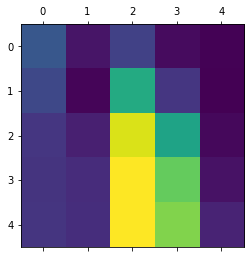

In [ ]:
# Generate class activation heatmap

heatmap = make_gradcam_heatmap(x, model, 'conv2d_31')

# Display heatmap
plt.matshow(heatmap)
plt.show()

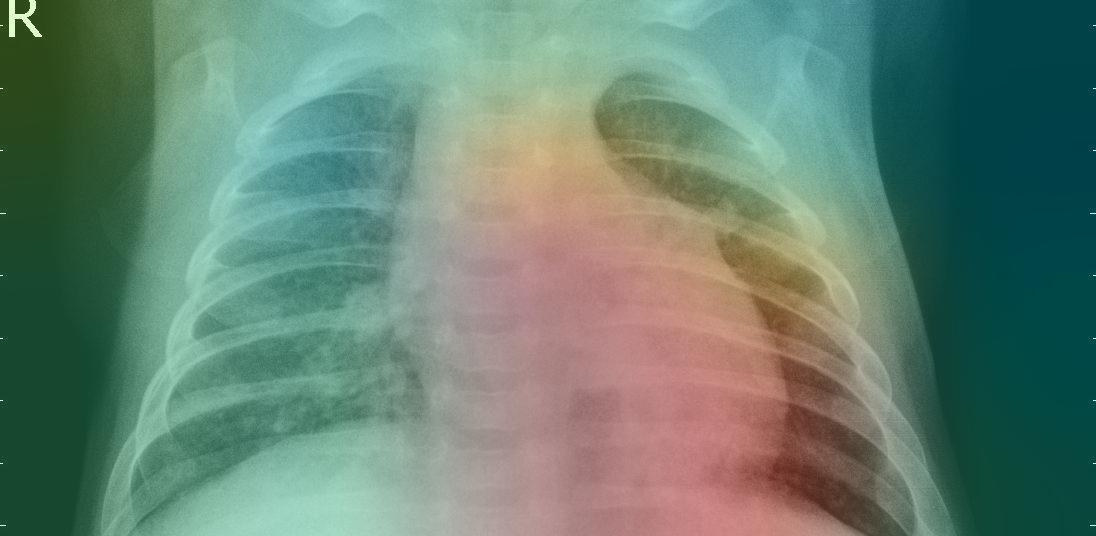

In [ ]:
save_and_display_gradcam(img_path, heatmap)

# Feature extraction from CNN

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 73, 73, 16)        160       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 34, 34, 32)        4640      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 5, 5, 128)        

In [ ]:
#Uses only the convolutional layers of the model

feature_extractor = models.Sequential()

for layer in model.layers[:-3]: #loops until the flattening layer
    feature_extractor.add(layer)

In [ ]:
csv_train = open('/root/data/DataSet/csv_train.csv', "w")
csv_val = open('/root/data/DataSet/csv_val.csv', "w")
csv_test = open('/root/data/DataSet/csv_test.csv', "w")

In [ ]:
#Extraction of features

features_train = feature_extractor.predict(train_set_fe,4101)
features_val = feature_extractor.predict(val_set_cm,878)
features_test = feature_extractor.predict(test_set,877)

In [ ]:
#Writtes the features in a csv file

#Adapted from https://www.pyimagesearch.com/2019/05/27/keras-feature-extraction-on-large-datasets-with-deep-learning/

for (label, vec) in zip(train_set_fe.classes, features_train):
			# construct a row that exists of the class label and
			# extracted features
			vec = ",".join([str(v) for v in vec])
			csv_train.write("{},{}\n".format(label, vec))
   
csv_train.close()

for (label, vec) in zip(val_set_cm.classes, features_val):
			# construct a row that exists of the class label and
			# extracted features
			vec = ",".join([str(v) for v in vec])
			csv_val.write("{},{}\n".format(label, vec))
   
csv_val.close()

for (label, vec) in zip(test_set.classes, features_test):
			# construct a row that exists of the class label and
			# extracted features
			vec = ",".join([str(v) for v in vec])
			csv_test.write("{},{}\n".format(label, vec))
   
csv_test.close()

# AdaBoost

In [ ]:
train = pd.read_csv('/root/data/DataSet/csv_train.csv', header = None)
val = pd.read_csv('/root/data/DataSet/csv_val.csv', header = None)
test = pd.read_csv('/root/data/DataSet/csv_test.csv', header = None)

In [ ]:
#Shuffles the rows in train val and test

train = train.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [ ]:
y_train = train[0]
x_train = train.drop(columns = 0)

y_val = val[0]
x_val = val.drop(columns = 0)

y_test = test[0]
x_test = test.drop(columns = 0)

In [ ]:
# AdaBoost = AdaBoostClassifier(random_state = 15)

# parameter_space_Ada = {
#     'n_estimators': [10,50,100],
#    'learning_rate': [1,0.1,0.01],
# }

# AdaBoost = GridSearchCV(AdaBoost, parameter_space_Ada, scoring='f1_micro', n_jobs = -1, cv=10)
# AdaBoost.fit(x_train, y_train)
# AdaBoost.best_params_
#{'learning_rate': 1, 'n_estimators': 100} 

{'learning_rate': 1, 'n_estimators': 100}

In [ ]:
AdaBoost = AdaBoostClassifier(n_estimators=100, learning_rate=1, random_state = 15)

AdaBoost.fit(x_train, y_train)

metrics_val(y_val, AdaBoost.predict(x_val))

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       238
           1       0.99      0.97      0.98       640

    accuracy                           0.97       878
   macro avg       0.96      0.97      0.96       878
weighted avg       0.97      0.97      0.97       878

[[229   9]
 [ 17 623]]
F1-score, micro:  0.9703872437357631


# K-Nearest Neighbors

In [ ]:
# knn = KNeighborsClassifier()

# parameter_space_knn = {
#     'n_neighbors': [1,5,10],
# }

# knn = GridSearchCV(knn, parameter_space_knn, scoring='f1_micro', n_jobs = -1, cv=10)
# knn.fit(x_train, y_train)
# knn.best_params_
# {'n_neighbors': 5}

{'n_neighbors': 5}

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(x_train, y_train)
metrics_val(y_val, knn.predict(x_val))

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       238
           1       0.99      0.97      0.98       640

    accuracy                           0.97       878
   macro avg       0.96      0.97      0.96       878
weighted avg       0.97      0.97      0.97       878

[[231   7]
 [ 19 621]]
F1-score, micro:  0.9703872437357631


# Random Forest

In [ ]:
# rf = RandomForestClassifier(max_features='sqrt', random_state=15)

# parameter_space_rf = {
#     'n_estimators': [10,25,50,100],
# }

# rf = GridSearchCV(rf, parameter_space_rf, scoring='f1_micro', n_jobs = -1, cv=10)
# rf.fit(x_train, y_train)
# rf.best_params_

{'n_estimators': 100}

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=15)

rf.fit(x_train, y_train)
metrics_val(y_val, rf.predict(x_val))

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       238
           1       0.99      0.97      0.98       640

    accuracy                           0.97       878
   macro avg       0.96      0.97      0.97       878
weighted avg       0.97      0.97      0.97       878

[[233   5]
 [ 19 621]]
F1-score, micro:  0.9726651480637815
